# Hourly Time Series Forecasting using Facebook's Prophet

##### In this notebook we will use facebook's prophet package to forecast hourly energy use.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

In [2]:
pjme = pd.read_csv('PJME_hourly.csv',index_col=[0], parse_dates=[0])

In [3]:
pjme

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


# Color pallete for plotting

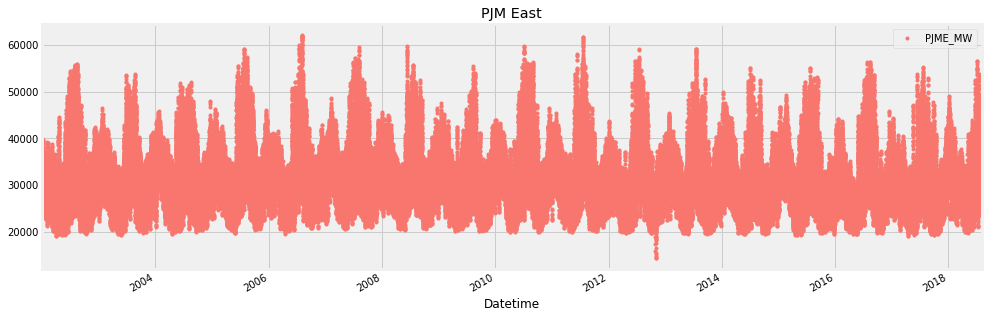

In [4]:
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

In [6]:
def create_features(df, label=None):

    #Creates time series features from datetime index.

    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)
features_and_target.head(3)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0


# Plotting the Features

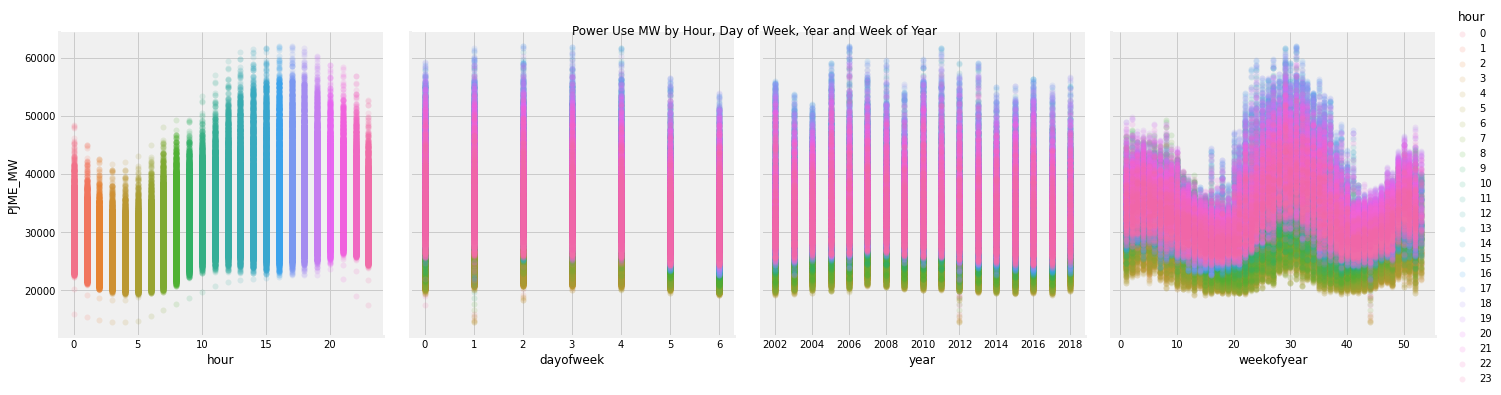

In [7]:
sns.pairplot(features_and_target.dropna(),hue='hour',x_vars=['hour','dayofweek','year','weekofyear'],
             y_vars='PJME_MW',height=5,plot_kws={'alpha':0.15, 'linewidth':0})

plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()


# Train/Test Split

In [8]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

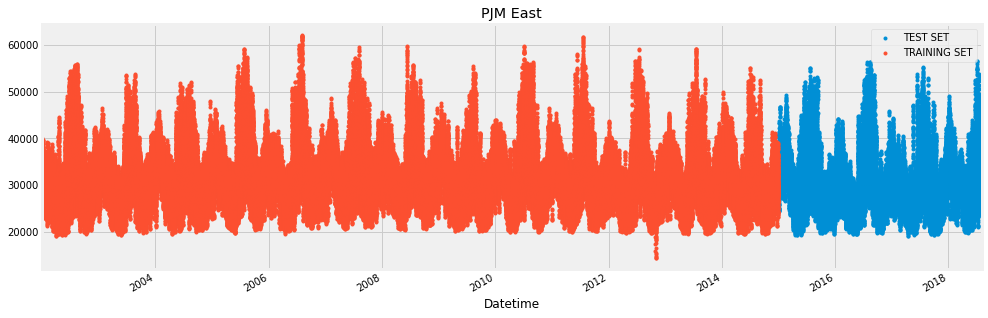

In [9]:
pjme_test.rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()


# Simple Prophet Model

In [10]:
pjme_train.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'}).head()


,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [13]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'}))

In [14]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index().rename(columns={'Datetime':'ds'}))

In [16]:
pjme_test_fcst.head()
#Prophet model expects the dataset to be named a specific way. 
#We will rename our dataframe columns before feeding it into the model.

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31222.751830,23767.345224,32697.055193,31222.751830,31222.751830,-2859.390279,-2859.390279,-2859.390279,-4430.401906,...,1281.399844,1281.399844,1281.399844,289.611783,289.611783,289.611783,0.0,0.0,0.0,28363.361551
1,2015-01-01 02:00:00,31222.716042,22102.007209,31302.335374,31222.716042,31222.716042,-4363.798060,-4363.798060,-4363.798060,-5927.339042,...,1272.641617,1272.641617,1272.641617,290.899366,290.899366,290.899366,0.0,0.0,0.0,26858.917982
2,2015-01-01 03:00:00,31222.680253,21481.987805,30076.412161,31222.680253,31222.680253,-5235.505146,-5235.505146,-5235.505146,-6790.411126,...,1262.677501,1262.677501,1262.677501,292.228479,292.228479,292.228479,0.0,0.0,0.0,25987.175107
3,2015-01-01 04:00:00,31222.644465,21219.844270,30400.287873,31222.644465,31222.644465,-5377.047623,-5377.047623,-5377.047623,-6922.277884,...,1251.631114,1251.631114,1251.631114,293.599147,293.599147,293.599147,0.0,0.0,0.0,25845.596841
4,2015-01-01 05:00:00,31222.608676,21946.667839,30965.448132,31222.608676,31222.608676,-4702.696009,-4702.696009,-4702.696009,-6237.345687,...,1239.638282,1239.638282,1239.638282,295.011396,295.011396,295.011396,0.0,0.0,0.0,26519.912668


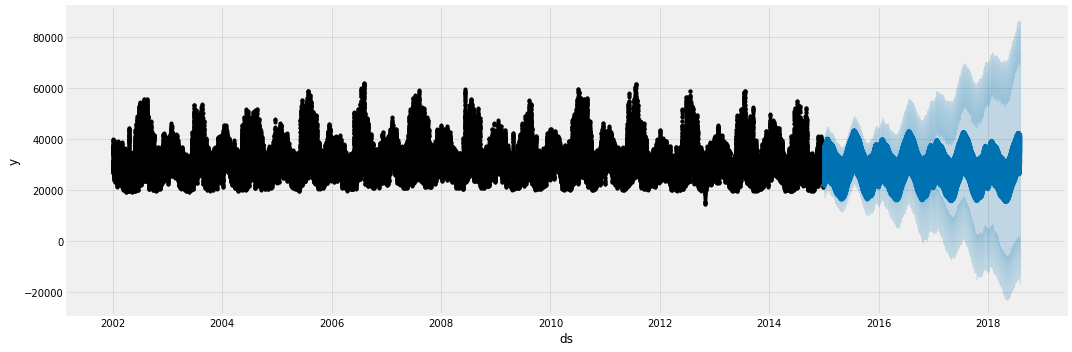

In [17]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

In [18]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from tensorflow.keras.layers import Dense,Dropout,SimpleRNN,LSTM
from tensorflow.keras.models import Sequential


In [20]:
df=pd.read_csv('DOM_hourly.csv')
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [21]:
df = pd.read_csv('DOM_hourly.csv', index_col='Datetime', parse_dates=['Datetime'])
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [22]:
df.isna().sum()

DOM_MW    0
dtype: int64

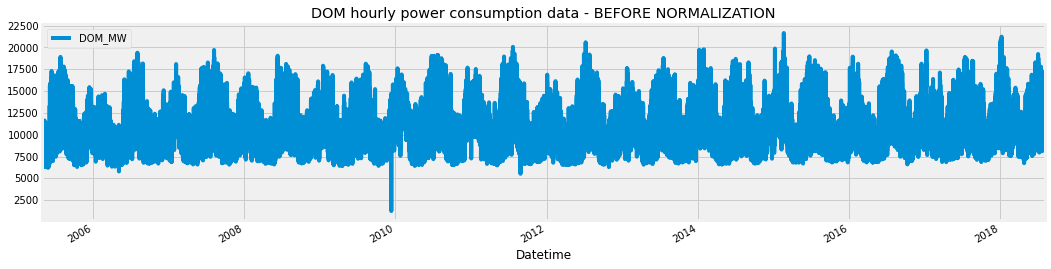

In [23]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

# Normalize data

In [24]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(116189, 1)

# Visualize data after normalization

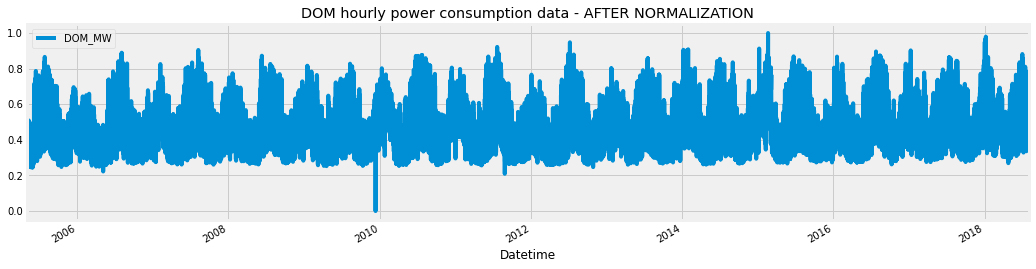

In [25]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [26]:
df_norm.shape

(116189, 1)

# Prepare data for training the RNN models

In [27]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [28]:
seq_len = 20

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


# Build a SIMPLE RNN model

In [29]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20, 40)            1680      
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [30]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Train on 110000 samples
Epoch 1/10
110000/110000 [==============================] - 17s 159us/sample - loss: 0.0741
Epoch 2/10
110000/110000 [==============================] - 11s 96us/sample - loss: 0.0181
Epoch 3/10
110000/110000 [==============================] - 10s 95us/sample - loss: 0.0104
Epoch 4/10
110000/110000 [==============================] - 12s 106us/sample - loss: 0.0072
Epoch 5/10
110000/110000 [==============================] - 12s 106us/sample - loss: 0.0057
Epoch 6/10
110000/110000 [==============================] - 12s 108us/sample - loss: 0.0046
Epoch 7/10
110000/110000 [==============================] - 13s 114us/sample - loss: 0.0039
Epoch 8/10
110000/110000 [==============================] - 13s 117us/sample - loss: 0.0034
Epoch 9/10
110000/110000 [==============================] - 13s 117us/sample - loss: 0.0031
Epoch 10/10
110000/110000 [==============================] - 13s 119us/sample - loss: 0.0027
